In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

## ↓(do, dh) = (0.01, 0.007) デフォルト

# Parameter set

In [2]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [3]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [4]:
def tSEIRD(v, t, a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap):
    g    = 0.2 - m         # E -> I 1/incubtation
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [5]:
def tSEIRD_matrix(Se,Sp,n,p,b,m,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [6]:
def tSEIRD_max(Se,Sp,n,p,b,m,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Dead'])
           ]

In [ ]:
v_b = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_b.append(tSEIRD_max(0.7,0.7,i,j,1,0.04))

np.savetxt('do001dh0007.csv',v_b,delimiter=',')

C:\Users\t_onishi\AppData\Local\Temp\ipykernel_32388\2662780073.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


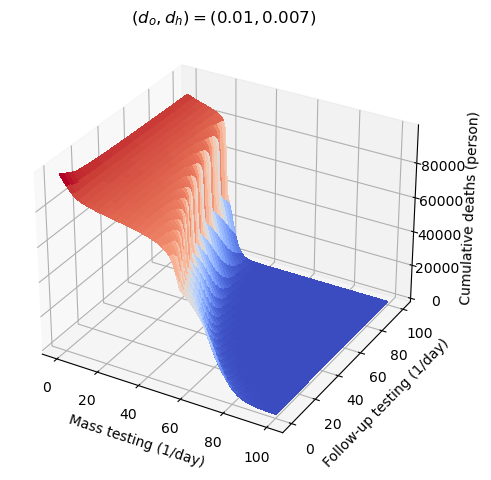

In [7]:
v_b = pd.read_csv('do001dh0007.csv',header=None)       
death_test_fix_b = np.array(v_b)[:,0].reshape((101,101))

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_b))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('$(d_{o}, d_{h}) = (0.01, 0.007)$')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(do, dh) = (0.01, 0.01) 入院しても治らない

# Parameter set

In [8]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
dh    = 0.01           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [9]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [10]:
def tSEIRD(v, t, a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap):
    g    = 0.2 - m         # E -> I 1/incubtation
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [11]:
def tSEIRD_matrix(Se,Sp,n,p,b,m,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [12]:
def tSEIRD_max(Se,Sp,n,p,b,m,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Dead'])
           ]

In [ ]:
v_b1 = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_b1.append(tSEIRD_max(0.7,0.7,i,j,1,0.04))

np.savetxt('do001dh001.csv',v_b1,delimiter=',')

C:\Users\t_onishi\AppData\Local\Temp\ipykernel_32388\2558424088.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


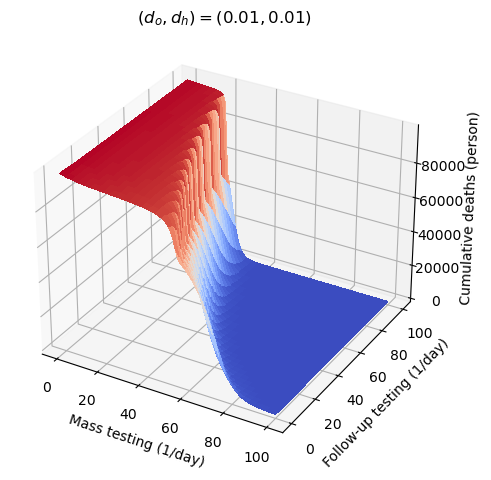

In [13]:
v_b = pd.read_csv('do001dh001.csv',header=None)       
death_test_fix_b = np.array(v_b)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_b))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('$(d_{o}, d_{h}) = (0.01, 0.01)$')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(do, dh) = (0.01, 0.001) 入院したらすごい治る

# Parameter set

In [14]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
dh    = 0.001           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [15]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [16]:
def tSEIRD(v, t, a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap):
    g    = 0.2 - m         # E -> I 1/incubtation
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [17]:
def tSEIRD_matrix(Se,Sp,n,p,b,m,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [18]:
def tSEIRD_max(Se,Sp,n,p,b,m,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Dead'])
           ]

In [ ]:
v_b2 = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_b2.append(tSEIRD_max(0.7,0.7,i,j,1,0.04))

np.savetxt('do001dh0001.csv',v_b2,delimiter=',')

C:\Users\t_onishi\AppData\Local\Temp\ipykernel_32388\350083670.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


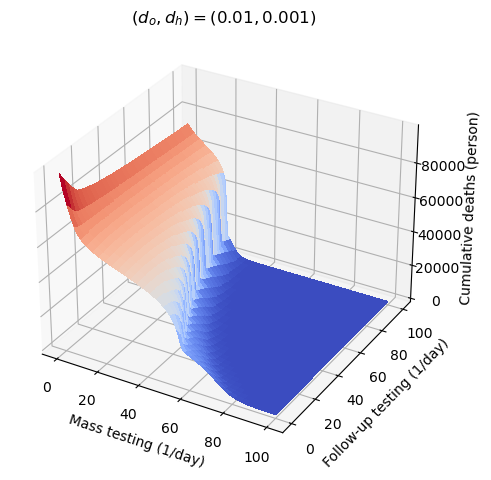

In [19]:
v_b = pd.read_csv('do001dh0001.csv',header=None)       
death_test_fix_b = np.array(v_b)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_b))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('$(d_{o}, d_{h}) = (0.01, 0.001)$')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(do, dh) = (0.001, 0.0007) 死亡率そもそも低い

# Parameter set

In [20]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
dh    = 0.0007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.001           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [21]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [22]:
def tSEIRD(v, t, a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap):
    g    = 0.2 - m         # E -> I 1/incubtation
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [23]:
def tSEIRD_matrix(Se,Sp,n,p,b,m,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [24]:
def tSEIRD_max(Se,Sp,n,p,b,m,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Dead'])
           ]

In [ ]:
v_b3 = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_b3.append(tSEIRD_max(0.7,0.7,i,j,1,0.04))

np.savetxt('do0001dh00007.csv',v_b3,delimiter=',')

C:\Users\t_onishi\AppData\Local\Temp\ipykernel_32388\1415280391.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


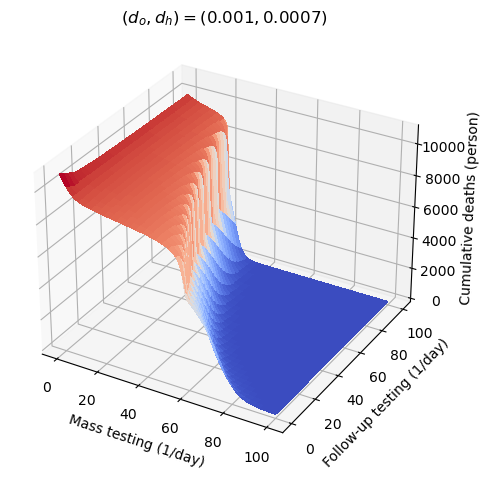

In [25]:
v_b = pd.read_csv('do0001dh00007.csv',header=None)       
death_test_fix_b = np.array(v_b)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_b))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('$(d_{o}, d_{h}) = (0.001, 0.0007)$')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# 断面図作るよー

In [27]:
do001dh0007 = pd.read_csv('do001dh0007.csv',header=None)       
death_0010007 = np.array(do001dh0007)[:,0].reshape((101,101))

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_0010007#/1000

plus_0010007 = []
for i in range(101):
    plus_0010007.append(Z[i,i].round(0))
    
minus_0010007 = []
for i in range(101):
    minus_0010007.append(Z[i,100-i].round(0))

In [28]:
do001dh0001 = pd.read_csv('do001dh0001.csv',header=None)       
death_0010001 = np.array(do001dh0001)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_0010001#/1000

plus_0010001 = []
for i in range(101):
    plus_0010001.append(Z[i,i].round(0))
    
minus_0010001 = []
for i in range(101):
    minus_0010001.append(Z[i,100-i].round(0))

In [29]:
do001dh001 = pd.read_csv('do001dh001.csv',header=None)       
death_001001 = np.array(do001dh001)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_001001#/1000

plus_001001 = []
for i in range(101):
    plus_001001.append(Z[i,i].round(0))
    
minus_001001 = []
for i in range(101):
    minus_001001.append(Z[i,100-i].round(0))

In [38]:
do001dh00007 = pd.read_csv('do0001dh00007.csv',header=None)       
death_00100007 = np.array(do001dh00007)[:,0].reshape((101,101))

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_00100007#/1000

plus_00100007 = []
for i in range(101):
    plus_00100007.append(Z[i,i].round(0))
    
minus_00100007 = []
for i in range(101):
    minus_00100007.append(Z[i,100-i].round(0))

Text(0, 0.5, 'Cumulative Deaths (Person)')

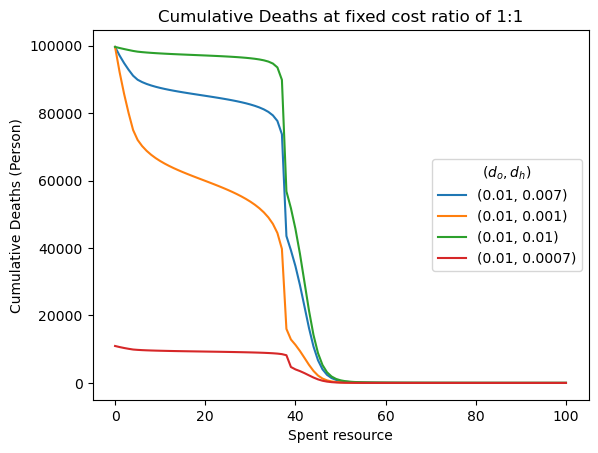

In [39]:
df_plus = pd.DataFrame(data={'0010007':plus_0010007,
                      '0010001':plus_0010001,
                      '001001':plus_001001,
                      '00100007':plus_00100007,
                            })

df_plus.plot(title='Cumulative Deaths at fixed cost ratio of 1:1')
plt.legend(['(0.01, 0.007)', '(0.01, 0.001)', '(0.01, 0.01)', '(0.01, 0.0007)'],
            loc='center right', title='$(d_{o}, d_{h})$')

plt.xlabel('Spent resource')
plt.ylabel('Cumulative Deaths (Person)')

Text(0, 0.5, 'Cumulative Deaths (Person)')

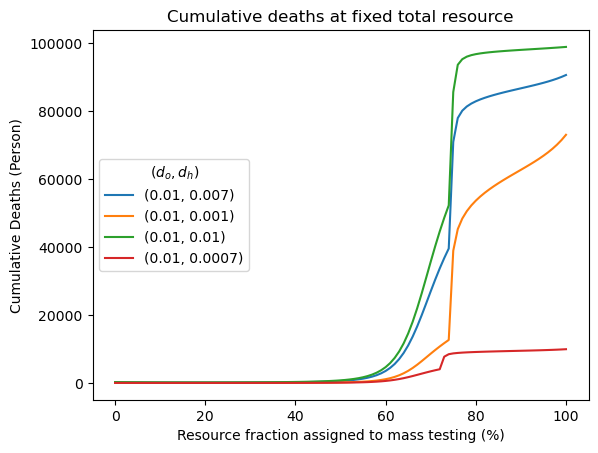

In [40]:
df_minus = pd.DataFrame(data={'0010007':minus_0010007,
                      '0010001':minus_0010001,
                      '001001':minus_001001,
                      '00100007':minus_00100007,
                            })

df_minus.plot(title='Cumulative deaths at fixed total resource')
plt.legend(['(0.01, 0.007)', '(0.01, 0.001)', '(0.01, 0.01)', '(0.01, 0.0007)'],
            loc='center left', title='$(d_{o}, d_{h})$')

plt.xlabel('Resource fraction assigned to mass testing (%)')
plt.ylabel('Cumulative Deaths (Person)')